In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_moons, make_circles
from sklearn.datasets import make_blobs # will be used to generate data which is not linearly separable.

## Let us first test how our Sigmoid neuron works on a set of data.

In [3]:
class SigmoidNeuron:
    
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))  

# above two functions does the forward pass.
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
          
      m = X.shape[1]  
      self.w -= learning_rate * dw/m  # we are here dividing by m because larger is the amount of data slower should be the learning rate we are normalising it. 
      self.b -= learning_rate * db/m
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

## Let us generate some non linearly separable data first.

In [13]:
data, labels = make_moons(n_samples=2000, random_state=0, noise=0.10)
print(data.shape, labels.shape)

(2000, 2) (2000,)


In [17]:
# number of classes we have 
len(set(labels))

2

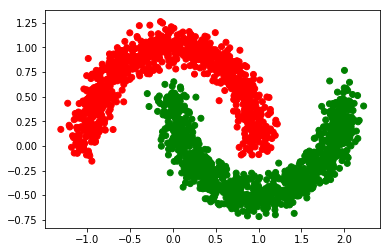

In [14]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue","green"])
np.random.seed(0)

plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap) # we have taken first two dimensions of our data only 
plt.show()

In [18]:
# train test split

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0) # validation set is similar to test set only.
print(X_train.shape, X_test.shape)

(1500, 2) (500, 2)


## Performing Sigmoid neuron classification.

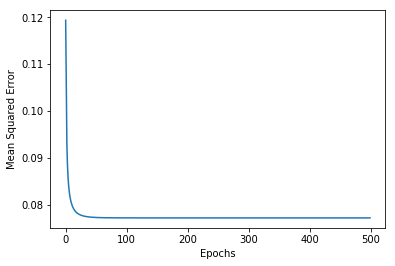

In [22]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=500, learning_rate=0.05, display_loss=True)

In [24]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_test = sn.predict(X_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_test = accuracy_score(Y_pred_binarised_test, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Test accuracy", round(accuracy_test, 2))

Training accuracy 0.89
Test accuracy 0.86


## Plotting our training data points based on how they are classified

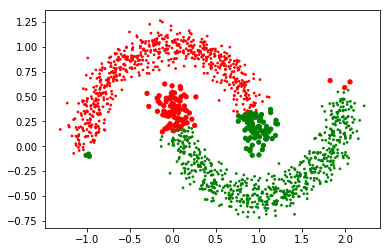

In [25]:
# let us plot what model is predicting actually
# we are setting the size also in s for points and the point will be of large size if the point is not correctly predicted.
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

## Points with larger size are not correctly classified.

## Plotting our test data points based on how they are classified

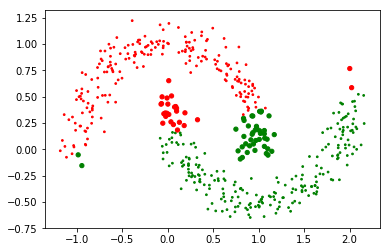

In [26]:
# let us plot what model is predicting actually
# we are setting the size also in s for points and the point will be of large size if the point is not correctly predicted.
plt.scatter(X_test[:,0], X_test[:,1], c=Y_pred_binarised_test, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_test-Y_test)+.2))
plt.show()

# Now we are not satisfied with the accuracy we received for such a simple model hence now we will try Feed Forward neural network for our classification purpose.

# Feed forward neural network

In [27]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):  # hidden sizes is a list which contains number of neurons in which layer
    self.nx = n_inputs
    self.ny = 1  # we are looking for binary classification
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {} # we will have matrix in dictionaries this refer to the matrix of W and b
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1) # initial h is the input itself 
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

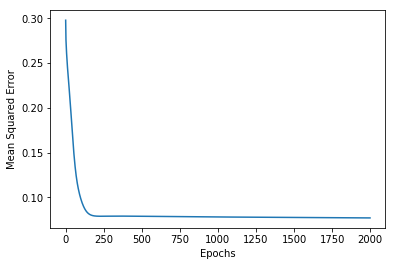

In [32]:
ffsnn = FFSNNetwork(2, [3,5])  # first layer will have 3 neurons and second layer will have 5 neurons
ffsnn.fit(X_train, Y_train, epochs=2000, learning_rate=.001, display_loss=True)

### Above you can see that the loss has gone down slowly here because here we had a deeper neural network in which we have more parameters hence they take time.

In [33]:
Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_test = ffsnn.predict(X_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_test = accuracy_score(Y_pred_binarised_test, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Test accuracy", round(accuracy_test, 2))

Training accuracy 0.89
Test accuracy 0.87


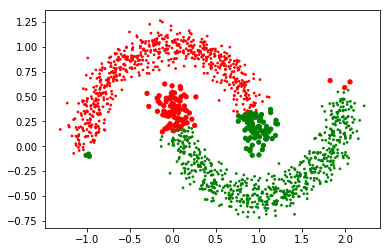

In [34]:
# let us plot what model is predicting actually
# we are setting the size also in s for points and the point will be of large size if the point is not correctly predicted.
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

### Test data predictions plotted

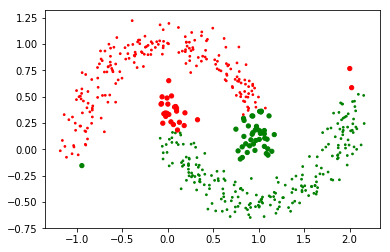

In [35]:
# let us plot what model is predicting actually
# we are setting the size also in s for points and the point will be of large size if the point is not correctly predicted.
plt.scatter(X_test[:,0], X_test[:,1], c=Y_pred_binarised_test, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_test-Y_test)+.2))
plt.show()